In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Uses gpu if available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

batch_size = 8

#Downloads datasets
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform) #Set download to true first time
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform) #Set download to true first time

#Split for cross validation
train_dataset, validation_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

#Creates DataLoaders for each set
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [109]:
#Defines Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self,):
        super().__init__()

        #Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=2, stride=1)
        self.pool3 = nn.MaxPool2d(2,2)

        #Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=64, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=10)


    def forward(self, x):
        #Convolutional layers with ReLU activation function
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        #Fully connected layers with ReLU activation
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        
        return x

In [ ]:
#Iterates through a training epoch while displaying performance metrics by batch
def train_epoch(network, optimizer, criterion):
    network.train(True)
    running_loss = 0.0
    running_accuracy = 0.0

    for batch_index, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = network(inputs)
        num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += num_correct / batch_size

        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_index % 500 == 499:
            avg_loss_across_batches = running_loss / 500
            avg_acc_across_batches = (running_accuracy / 500) * 100
            print('Batch{0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1, avg_loss_across_batches, avg_acc_across_batches))
            running_loss = 0
            running_accuracy = 0

#Optional method to evaluate performance on validation data
def validate_epoch(network, criterion):
    network.train(False)
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(valloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs = network(inputs)
            num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += num_correct / batch_size

            loss = criterion(outputs, labels)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(valloader)
    avg_accuracy_across_batches = (running_accuracy / len(valloader)) * 100
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches, avg_accuracy_across_batches))
    print('*****************************************')
    print()
            

In [ ]:
#Sets up CNN, optimizer, and loss function
cnn = CNN()
cnn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.0001)

#Trains the CNN
num_epochs = 2
for i in range(num_epochs):
    print(f"Epoch {i+1}")
    train_epoch(cnn, optimizer, criterion)
    validate_epoch(cnn, criterion)

Epoch 1
Batch500, Loss: 2.284, Accuracy: 15.8%
Batch1000, Loss: 1.468, Accuracy: 58.9%
Batch1500, Loss: 0.806, Accuracy: 75.9%
Batch2000, Loss: 0.589, Accuracy: 82.8%
Batch2500, Loss: 0.467, Accuracy: 86.5%
Batch3000, Loss: 0.395, Accuracy: 88.3%
Batch3500, Loss: 0.367, Accuracy: 89.1%
Batch4000, Loss: 0.350, Accuracy: 89.5%
Batch4500, Loss: 0.305, Accuracy: 91.1%
Batch5000, Loss: 0.301, Accuracy: 90.9%
Batch5500, Loss: 0.268, Accuracy: 92.1%
Batch6000, Loss: 0.266, Accuracy: 91.5%
Val Loss: 0.257, Val Accuracy: 91.9%
*****************************************

Epoch 2
Batch500, Loss: 0.248, Accuracy: 92.2%
Batch1000, Loss: 0.229, Accuracy: 93.3%
Batch1500, Loss: 0.213, Accuracy: 94.0%
Batch2000, Loss: 0.236, Accuracy: 93.1%
Batch2500, Loss: 0.219, Accuracy: 93.0%
Batch3000, Loss: 0.221, Accuracy: 93.7%
Batch3500, Loss: 0.205, Accuracy: 93.8%
Batch4000, Loss: 0.200, Accuracy: 94.0%
Batch4500, Loss: 0.190, Accuracy: 94.2%
Batch5000, Loss: 0.179, Accuracy: 94.4%
Batch5500, Loss: 0.178, Ac

In [155]:
#Verifies accuracy on test data set
total_correct = 0
for batch_index, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = cnn(inputs)
        total_correct += torch.sum(labels == torch.argmax(outputs, dim=1)).item()
print(f"Accuracy {(total_correct/len(test_dataset)) * 100}")

Accuracy 94.91000000000001


In [156]:
test_iter = iter(testloader)

True label: 3
Guess label: 3


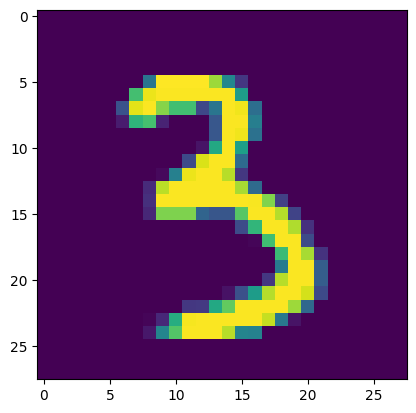

In [161]:
#Shows an image along with a guess and true label
images, true_labels = next(test_iter)
cnn.train(False)
guess_labels = cnn(images.to(device))
np_imgs = images.numpy()
np_img = np_imgs[0]
guess_label = torch.argmax(guess_labels[0]).item()
print(f"True label: {true_labels[0]}")
print(f"Guess label: {guess_label}")
plt.imshow(np_img.reshape((28,28,1)))